# The effect of adjusting for precision variables


ref: https://rpubs.com/kaz_yos/non-collapsibility2

### Linear regression 

$e$ = exposure (randomized)    
$p_1$ = predictor variable 1 (Not confounding == not associated with $e$)    
$p_2$ = predictor variable 2    

$Y = \beta_0 + \beta_1 e + \beta_2 p_1 + \beta_3 p_2 + \epsilon$


Fully conditional model of this Y is,

$$E[Y | e, p_1, p_2] = \beta_0 + \beta_1 e + \beta_2 p_1 + \beta_3 p_2$$

However, Margianl model 

$$E[Y|e] = \beta_0 + \beta_1 e$$

should have the unbiased estimator of $\beta_1$ because $e$ was randomized.

Indeed,

$$E[Y|e] = \beta_0 + \beta_1 e + \beta_2 E[p_1 | e] + \beta_2 E[p_2 | e]$$

And because $p_1$ and $p_2$ are not associated with $e$, they are constant when conditioned on $e$.    
thus,

$$E(Y|e) = \beta_0^* + \beta_1 e$$

The $\beta_1$ from the marginal model is the same as the fully conditional model but with a larger SE.

### Logistic regression 

$log(OR) = \beta_0 + \beta_1 e + \beta_2 p_1 + \beta_3 p_2 + \epsilon$    
(*$log(E[OR]) = \frac{}{1-p}$)

**Marginal model**

$$log\left(\frac{E(Y)}{1 - E(Y)}\right) = \beta_0 + \beta_1 e$$

**Conditioned model**

$$log\left(\frac{E(Y|e, p_1, p_2)}{1 - E(Y|e, p_1, p_2)}\right) = \beta_0 + \beta_1 e + \beta_2 p_1 + \beta_2 p_2$$


In [17]:
library(magrittr)
library(dplyr)
library(reshape2)
library(ggplot2)

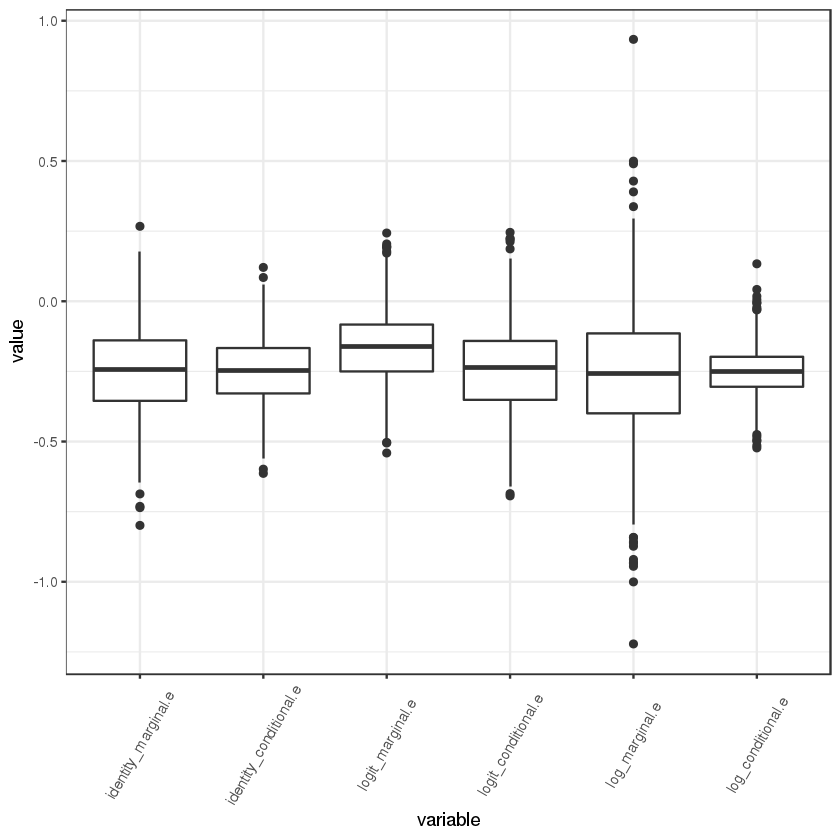

In [8]:
Simulate <- function(N=1000) {
  ## Outcome predictor 1
  p1 <- rnorm(n = N, mean = 0.3, sd = 0.6)
  ## Outcome predictor 2 associated with predictor 1
  p2 <- rnorm(n = N, mean = -0.4, sd = 0.8) + (p1/7)*runif(n = N)
  ## Randomly assign exposure
  e <- rbinom(n = N, size = 1, prob = 0.5)
  ## Set true model parameters
  beta0 <-  1
  beta1 <- -0.25
  beta2 <-  1.2
  beta3 <-  1.8
  ## Continuous outcome under the true model
  Ycont <- beta0 + beta1*e + beta2*p1 + beta3*p2 + rnorm(n = N, mean = 0, sd = 2)
  ## Dichotomized outcome variable Ydich
  # Ydich <- as.numeric(Ycont > median(Ycont))
  EXPs=exp(beta0 + beta1*e + beta2*p1 + beta3*p2 + rnorm(n = N, mean = 0, sd = 0.4))
  Ps = EXPs/(1+EXPs)
  Ydich = rbinom(N,1,Ps)
  Ycount=rpois(N, EXPs)
  ## Identity link: Conditional effect of exposure
  identity_conditional_coef_e <-
    glm(Ycont ~ e + p1 + p2, family = gaussian(link = "identity")) %>%
    coef %>% extract("e")
  ## Identity link: Marginal effect of exposure (valid estimate as the exposure is randomized)
  identity_marginal_coef_e <-
    glm(Ycont ~ e, family = gaussian(link = "identity")) %>%
    coef %>% extract("e")
  
  ## Logit link: Conditional effect of exposure
  logit_conditional_coef_e <-
    glm(Ydich ~ e + p1 + p2, family = binomial(link = "logit")) %>%
    coef %>% extract("e")
  ## Logit link: Marginal effect of exposure (valid estimate as the exposure is randomized)
  logit_marginal_coef_e <-
    glm(Ydich ~ e, family = binomial(link = "logit")) %>%
    coef %>% extract("e")
  
  ## Log link: Conditional effect of exposure
  log_conditional_coef_e <- 
    glm(Ycount ~ e + p1 + p2, family = poisson(link = "log")) %>% 
    coef %>% extract("e")
  ## Log link: Marginal effect of exposure (valid estimate as the exposure is randomized)
  log_marginal_coef_e <- 
    glm(Ycount ~ e, family = poisson(link = "log")) %>% 
    coef %>% extract("e")
  
  ##
  c(identity_marginal    = identity_marginal_coef_e,
    identity_conditional = identity_conditional_coef_e,
    logit_marginal       = logit_marginal_coef_e,
    logit_conditional    = logit_conditional_coef_e,
    log_marginal         = log_marginal_coef_e,
    log_conditional      = log_conditional_coef_e)
}

set.seed(20150117)
resSims <- sapply(1:1000, function(x){Simulate()}) %>%
  t %>% data.frame %>% 
  melt(data          = .,
       id.vars       = NULL,
       variable.name = "variable",
       value.name    = "value")

ggplot(data = resSims, mapping = aes(x = variable, y = value)) +
  geom_boxplot() + 
  theme_bw() + theme(legend.key = element_blank(),
                     axis.text.x = element_text(angle = 60, vjust = 0.5))

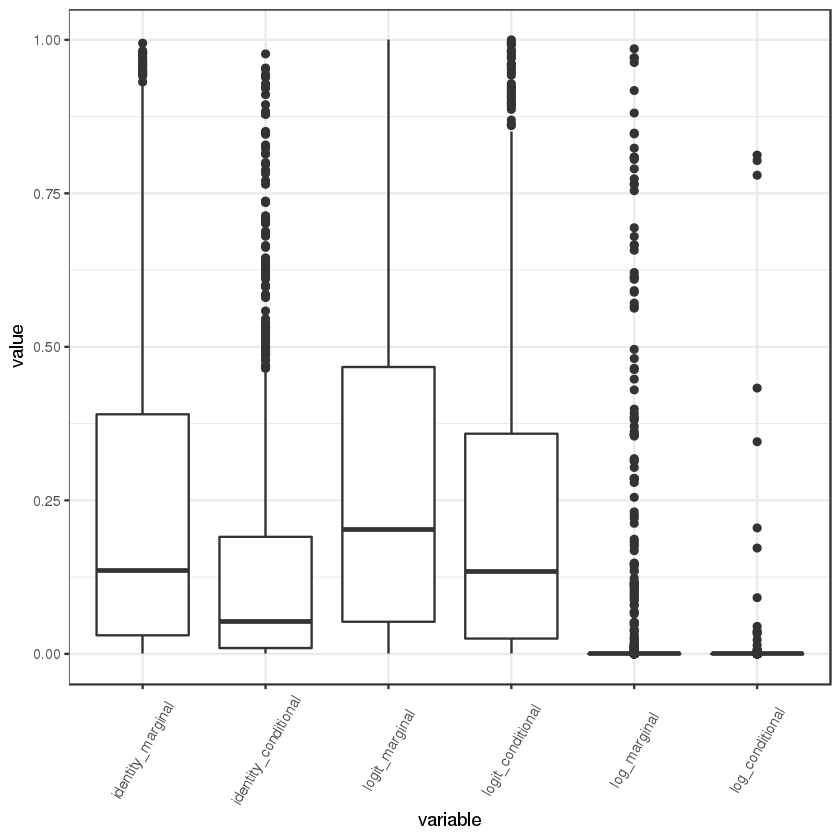

In [9]:
Simulate <- function(N=1000) {
  ## Outcome predictor 1
  p1 <- rnorm(n = N, mean = 0.3, sd = 0.6)
  ## Outcome predictor 2 associated with predictor 1
  p2 <- rnorm(n = N, mean = -0.4, sd = 0.8) + (p1/7)*runif(n = N)
  ## Randomly assign exposure
  e <- rbinom(n = N, size = 1, prob = 0.5)
  ## Set true model parameters
  beta0 <-  1
  beta1 <- -0.25
  beta2 <-  1.2
  beta3 <-  1.8
  ## Continuous outcome under the true model
  Ycont <- beta0 + beta1*e + beta2*p1 + beta3*p2 + rnorm(n = N, mean = 0, sd = 2)
  ## Dichotomized outcome variable Ydich
  # Ydich <- as.numeric(Ycont > median(Ycont))
  EXPs=exp(beta0 + beta1*e + beta2*p1 + beta3*p2 + rnorm(n = N, mean = 0, sd = 0.4))
  Ps = EXPs/(1+EXPs)
  Ydich = rbinom(N,1,Ps)
  Ycount=rpois(N, EXPs)
   ## Identity link: Conditional effect of exposure
  identity_conditional_p_e <-
    glm(Ycont ~ e + p1 + p2, family = gaussian(link = "identity")) %>%
    summary %>% coefficients %>% .[2,4]
  ## Identity link: Marginal effect of exposure (valid estimate as the exposure is randomized)
  identity_marginal_p_e <-
    glm(Ycont ~ e, family = gaussian(link = "identity")) %>%
    summary %>% coefficients %>% .[2,4]
  
  ## Logit link: Conditional effect of exposure
  logit_conditional_p_e <- 
    glm(Ydich ~ e + p1 + p2, family = binomial(link = "logit")) %>% 
    summary %>% coefficients %>% .[2,4]
  ## Logit link: Marginal effect of exposure (valid estimate as the exposure is randomized)
  logit_marginal_p_e <- 
    glm(Ydich ~ e , family = binomial(link = "logit")) %>% 
    summary %>% coefficients %>% .[2,4]

  ## Log link: Conditional effect of exposure
  log_conditional_p_e <- 
    glm(Ycount ~ e + p1 + p2, family = poisson(link = "log")) %>% 
    summary %>% coefficients %>% .[2,4]
  ## Log link: Marginal effect of exposure (valid estimate as the exposure is randomized)
  log_marginal_p_e <- 
    glm(Ycount ~ e, family = poisson(link = "log")) %>% 
    summary %>% coefficients %>% .[2,4]
  
  c(identity_marginal    = identity_marginal_p_e,
    identity_conditional = identity_conditional_p_e,
    logit_marginal       = logit_marginal_p_e,
    logit_conditional    = logit_conditional_p_e,
    log_marginal         = log_marginal_p_e,
    log_conditional      = log_conditional_p_e)
}

set.seed(20150117)
resSims <- sapply(1:1000, function(x){Simulate()}) %>%
  t %>% data.frame %>% 
  melt(data          = .,
       id.vars       = NULL,
       variable.name = "variable",
       value.name    = "value")

ggplot(data = resSims, mapping = aes(x = variable, y = value)) +
  geom_boxplot() + 
  theme_bw() + theme(legend.key = element_blank(),
                     axis.text.x = element_text(angle = 60, vjust = 0.5))

In [16]:
# power
resSims %>% mutate(reject=ifelse(value<0.05, 1, 0)) %>% group_by(variable) %>% summarize_at(vars("reject"), sum)

variable,reject
identity_marginal,314
identity_conditional,496
logit_marginal,244
logit_conditional,337
log_marginal,905
log_conditional,992
